In [42]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from shutil import copyfileobj
from urllib import request
import os
import uuid
import xlwings as xw
import re
from datetime import datetime
import time
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.api import OLS as LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error as MSE, accuracy_score, precision_score, f1_score, recall_score, r2_score
import plotly.graph_objects as go

Acquérir l'ensemble des fichiers Excel des classements via la page de classement

In [2]:
def get_file_names():
    url = "https://www.vendeeglobe.org/fr/classement"
    source = request.urlopen(url).read()
    soup = BeautifulSoup(source, "lxml")

    select = soup.find('select', attrs={'class': 'form__input m--select onsubmit-rank'})
    option = select.findAll('option')
    option_values = [option.get('value') for option in option if option.get('value') != '']

    option_values = np.unique(option_values)
    
    return option_values

Mettre en place une copie locale des fichiers Excel afin de ne pas les recharger à chaque run.

In [3]:
def get_excel_files(PATH='./Files/'):
    file_names = get_file_names()
    
    urls = ["https://www.vendeeglobe.org/download-race-data/vendeeglobe_" + filename + \
            ".xlsx" for filename in file_names]
    
    for i, url in enumerate(urls):
        filename = "vendeeglobe_" + file_names[i] + ".xlsx"
        
        with request.urlopen(url) as response, open(os.path.join(PATH, filename), 'wb') as out_file:
            copyfileobj(response, out_file)

In [4]:
PATH = './Files/'

try:
    os.mkdir(PATH)
except:
    pass

if not os.listdir(PATH):
    get_excel_files(PATH)
else:
    print('Requirement already satisfied')

In [5]:
def save_usable_xlsx(READ_PATH, SAVE_PATH):
    
    def save_with_xlwings(READ_PATH, SAVE_PATH, filename):
        tempfile = SAVE_PATH + filename
        excel_app = xw.App(visible=False)
        excel_book = excel_app.books.open(READ_PATH)
        excel_book.save(tempfile)
        excel_book.close()
        excel_app.quit()
        return tempfile
    
    file_names = os.listdir(READ_PATH)

    for filename in file_names:
        save_with_xlwings(READ_PATH + '/' + filename, SAVE_PATH, filename)

In [6]:
SAVE_PATH = './XLS_FILES/'

try:
    os.mkdir(SAVE_PATH)
except:
    pass

if not os.listdir(SAVE_PATH):
    save_usable_xlsx(PATH, SAVE_PATH)
else:
    print('Requirement already satisfied')

Acquérir les caractéristiques des bateaux.

In [7]:
def get_boat_caracteristics():
    url = "https://www.vendeeglobe.org/fr/glossaire"
    source = request.urlopen(url).read()

    soup = BeautifulSoup(source, "lxml")

    div_specs = soup.findAll('div', attrs={'class': 'boats-list__popup mfp-hide'})
    
    div_boat_info = soup.findAll('div', attrs={'class': 'boats-list__infos'})
    
    boat_skipper = []
    
    for tags in div_boat_info:
        boatname = tags.find('h3', 'boats-list__boat-name').text.upper()
        skippername = tags.find('span', 'boats-list__skipper-name').text.upper()
        boat_skipper.append((boatname, skippername))

    result = []
    for i, tags in enumerate(div_specs):
        ul = tags.findAll('ul', attrs={"ul", "boats-list__popup-specs-list"})

        for specs in ul:
            pattern = re.compile('(.*):(.*)')
            matches = pattern.findall(specs.text)

            tmp = {}
            for pair in matches:
                key = pair[0].strip()
                value = pair[1].strip()
                tmp["Bateau"] = boat_skipper[i][0]
                tmp['Skipper'] = boat_skipper[i][1]
                tmp[key] = value

            result.append(tmp)

    return pd.DataFrame(result)

In [8]:
def clean_boat_caracteristics(df):
    column_to_drop = 'Chantier : CDK Technologies / Assemblage'

    if column_to_drop in df.columns: 
        df = df.drop(column_to_drop, axis=1)

    df = df.drop(df.loc[df["Bateau"]==""].index)
    
    df['Bateau'] = df['Bateau'].apply(lambda row: row.strip())

    def convert_to_float(distance):
        distance = distance.replace(" ", "")
        distance = distance.replace(",", ".")

        return float(distance[:-1])

    columns_to_convert = ['Hauteur mât', 'Longueur', 'Largeur', 'Tirant d\'eau']

    for column in columns_to_convert:
        df[column] = df[column].apply(lambda row: convert_to_float(row))

    columns_to_convert = ['Surface de voiles au près', 'Surface de voiles au portant']

    for column in columns_to_convert:
        df[column] = df[column].apply(lambda row: float(row[:-2]))

    def convert_weight_to_float(weight):
        weight = weight.replace(" ", "")
        weight = weight.replace(",", ".")
        weight = weight.replace("tonnes","t")
        weight = weight.replace("NC","9t")
        weight = weight.replace("nc","9t")

        return float(weight[:-1])

    df['Déplacement (poids)'] = df['Déplacement (poids)'].apply(lambda row: convert_weight_to_float(row))

    def convert_derives_foils(nb):
        nb = nb.replace('foils', '0')
        nb = nb.replace(' ', '')
        nb = nb.replace('asymétriques', '')
        nb = nb.replace('foiler', '0')

        return int(nb)

    df['Nombre de dérives'] = df['Nombre de dérives'].apply(lambda row: convert_derives_foils(row))
    df['Dérive / Foil'] = df['Nombre de dérives'].apply(lambda row: 0 if row > 0 else 1)
    df = df.drop('Nombre de dérives', axis = 1)

    def convert_french_date_to_datetime(date):
        date = date.replace(' ', '-')
        date = date.replace('Août', '08')
        date = date.replace('Mars', '03')
        date = date.replace('Juin', '06')
        date = date.replace('Février', '02')
        date = date.replace('Septembre', '09')
        date = date.replace('Janvier', '01')
        date = date.replace('Mai', '05')
        date = date.replace('Avril', '04')
        date = date.replace('Juillet', '07')

        return datetime.strptime(date, '%d-%m-%Y')

    df['Date de lancement'] = df['Date de lancement'].apply(lambda row: convert_french_date_to_datetime(row))
        
    incorrect_spelling = ['YES WE CAM!', 'V AND B-MAYENNE', 'PURE - BEST WESTERN®', 'COMPAGNIE DU LIT / JILITI', \
                          'NEWREST - ART & FENÊTRES', 'BUREAU VALLEE 2', 'INITIATIVES-COEUR', 'CORUM L\'EPARGNE']
    
    correct_spelling = ['YES WE CAM !', 'V AND B MAYENNE', 'PURE - BEST WESTERN HOTELS AND RESORTS', \
                        'COMPAGNIE DU LIT - JILITI', 'NEWREST - ART ET FENETRES', 'BUREAU VALLÉE 2', \
                        'INITIATIVES - COEUR', 'CORUM L\'ÉPARGNE']
    
    df.at[2, 'Bateau'] = 'TSE - 4MYPLANET'
    df.at[11, 'Skipper'] = 'Samantha Davies'
    df.at[25, 'Skipper'] = 'Alan Roura'
    df.at[5, 'Skipper'] = 'Arnaud Boissieres'

    for i in range(len(incorrect_spelling)):
        index = df.loc[df['Bateau']==incorrect_spelling[i]].index[0]
        df.at[index, 'Bateau'] = correct_spelling[i]

    df['Skipper'] = df['Skipper'].apply(lambda row: row.title())
    
    incorrect_spelling = ['FRA72', '17', '08', '18', 'FRA30', 'FRA109', '69', 'FRA09', 'FRA83', 'GBR77', '16', \
                          'FIN222', '001', 'FRA50', 'SUI07', '2', 'FRA53', 'FRA1000', '4']
    
    correct_spelling = ['FRA 72', 'FRA 17', 'FRA 8', 'FRA 18', 'FRA 30', 'FRA 109', 'FRA 69', 'FRA 09', \
                        'FRA 83', 'GBR 777', 'MON 10', 'FIN 222', 'FRA 01', 'FRA 50', 'SUI 7', 'FRA 02', \
                        'FRA 53', 'FRA 1000', 'FRA 4']

    for i in range(len(incorrect_spelling)):
        index = df.loc[df['Numéro de voile']==incorrect_spelling[i]].index[0]
        df.at[index, 'Numéro de voile'] = correct_spelling[i]
    
    index = df.loc[df['Numéro de voile'].isna()].index[0]
    df.at[index, 'Numéro de voile'] = 'FRA 59'
    
    df["Ancienneté du bateau"] = df['Date de lancement'].apply(lambda row : (datetime.now() - row).days)
    
    df = df.drop(['Anciens noms du bateau', 'Chantier', 'Voile quille', 'Architecte'], axis = 1)
    
    return df

In [9]:
boat_df = get_boat_caracteristics()
boat_df = clean_boat_caracteristics(boat_df)

Préparation des données relatives aux classements.

In [10]:
def convert_excel_to_dataframe(filename):
    column_names = ['Unnamed: 0', 'Rang', 'Nat. / Voile', 'Skipper / Bateau', 'Heure FR', 'Latitude', \
                    'Longitude', 'Depuis 30 minutes - Cap', 'Depuis 30 minutes - Vitesse', \
                    'Depuis 30 minutes - VMG', 'Depuis 30 minutes - Distance', \
                    'Depuis le dernier classement - Cap', 'Depuis le dernier classement - Vitesse', \
                    'Depuis le dernier classement - VMG', 'Depuis le dernier classement - Distance', \
                    'Depuis 24 heures - Cap', 'Depuis 24 heures - Vitesse', 'Depuis 24 heures - VMG', \
                    'Depuis 24 heures - Distance', 'DTF', 'DTL']

    df = pd.read_excel(SAVE_PATH + filename, skiprows=4, names = column_names)
    df = df.drop('Unnamed: 0', axis = 1)
    df = df.dropna()
    
    year = filename[12:16]
    month = filename[16:18]
    day = filename[18:20]
    heure = int(filename[21:23]) + 1
    
    date = year + '-' + month + '-' + day + ' ' + str(heure)
    date = datetime.strptime(date, '%Y-%m-%d %H')
    
    df['Date'] = date
    
    return df

In [11]:
def clean_dataframe(df):
    def convert_hour(hour):
        hour = hour[:5]
        time = datetime.strptime(hour, '%H:%M')
        return time.strftime('%H:%M')

    df['Heure FR'] = df['Heure FR'].apply(lambda row: convert_hour(row))

    def convert_units(unit):
        unit = unit.replace(' ', '')
        unit = unit.replace('°', '')
        unit = unit.replace('kts', '')
        unit = unit.replace('nm', '')

        return float(unit)

    columns = ['Depuis 30 minutes - Cap', 'Depuis 30 minutes - Vitesse', 'Depuis 30 minutes - VMG', \
               'Depuis 30 minutes - Distance', 'Depuis le dernier classement - Cap', \
               'Depuis le dernier classement - Vitesse', 'Depuis le dernier classement - VMG', \
               'Depuis le dernier classement - Distance', 'Depuis 24 heures - Cap', \
               'Depuis 24 heures - Vitesse', 'Depuis 24 heures - VMG', 'Depuis 24 heures - Distance', \
               'DTF', 'DTL']

    for column in columns:
        if df[column].dtype != 'float64':
            df[column] = df[column].apply(lambda row: convert_units(row))

    def parse_nat(nat):
        nat = nat.split('\n')

        return nat[1]

    df['Nat. / Voile'] = df['Nat. / Voile'].apply(lambda row: parse_nat(row))
    
    df = df.rename(columns={'Nat. / Voile': 'Numéro de voile'})

    df['Rang'] = df['Rang'].apply(lambda row: int(row))

    df[['Skipper', 'Bateau']] = df['Skipper / Bateau'].str.split('\n', expand=True)
    
    df['Bateau'] = df['Bateau'].apply(lambda row: row.upper())
    df = df.drop('Skipper / Bateau', axis = 1)
    
    def dms2decpd(s):
        if type(s)==float:
            dec = s
        else:    
            lis=s.replace("°", ".").replace("'", ".").split(".")
            if lis[3] == "E" or lis[3] =='N':
                dec = int(lis[0]) + int(lis[1])/60 + int(lis[2]) /3600
            else:
                dec= -(int(lis[0]) + int(lis[1])/60 + int(lis[2]) /3600)
        return dec

    df["Latitude"] = df["Latitude"].apply(lambda x : dms2decpd(x))
    df["Longitude"] = df["Longitude"].apply(lambda x : dms2decpd(x))

    display_order = ['Date', 'Rang', 'Numéro de voile', 'Skipper', 'Bateau', 'Heure FR', 'Latitude', 'Longitude' , \
                     'Depuis 30 minutes - Cap', 'Depuis 30 minutes - Vitesse', 'Depuis 30 minutes - VMG', \
                     'Depuis 30 minutes - Distance', 'Depuis le dernier classement - Cap', \
                     'Depuis le dernier classement - Vitesse', 'Depuis le dernier classement - VMG', \
                     'Depuis le dernier classement - Distance', 'Depuis 24 heures - Cap', \
                     'Depuis 24 heures - Vitesse', 'Depuis 24 heures - VMG', 'Depuis 24 heures - Distance', \
                     'DTF', 'DTL']

    df = df[display_order]
    
    return df

In [12]:
def load_all_excel_files(PATH):
    dataframes = []
    
    files_to_ignore = ['vendeeglobe_20210305_080000.xlsx', 'vendeeglobe_20201108_120200.xlsx']
    
    for filename in os.listdir(PATH):
        if filename not in files_to_ignore:
            df = convert_excel_to_dataframe(filename)
            df = clean_dataframe(df)
            dataframes.append(df)
    
    return dataframes

In [13]:
def clean_final_dataframe(df):
    
    dfs = [df.set_index('Date') for df in dataframes]
    dfs = pd.concat(dfs, axis=0)
    dfs = dfs.reset_index()
    dfs = dfs.sort_values(['Date'], ascending=[True])
    dfs = dfs.reset_index()
    dfs = dfs.drop('index', axis = 1)
    
    return dfs

In [14]:
dataframes = load_all_excel_files(SAVE_PATH)
df = clean_final_dataframe(dataframes)

Rapprochement des données des voiliers avec celle des classements.

In [15]:
data = pd.merge(df,
                boat_df,
                left_on='Skipper',
                right_on='Skipper',
                how='left')
data = data.rename(columns={'Bateau_x': 'Bateau', 'Numéro de voile_x': 'Numéro de voile'})
data = data.drop(['Bateau_y', 'Numéro de voile_y'], axis = 1)
data = data.sort_values(['Date', 'Rang'], ascending=[True, True])
data = data.reset_index()
data = data.drop('index', axis = 1)

In [16]:
data.head(30)

,Date,Rang,Numéro de voile,Skipper,Bateau,Heure FR,Latitude,Longitude,Depuis 30 minutes - Cap,Depuis 30 minutes - Vitesse,...,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Hauteur mât,Surface de voiles au près,Surface de voiles au portant,Dérive / Foil,Ancienneté du bateau
0,2020-11-08 15:00:00,1,FRA 18,Louis Burton,BUREAU VALLÉE 2,15:30,46.412778,-1.846667,241.0,17.7,...,2015-06-09,18.28,5.80,4.5,7.6,28.0,300.0,600.0,1,2735
1,2020-11-08 15:00:00,2,MON 10,Boris Herrmann,SEAEXPLORER - YACHT CLUB DE MONACO,15:31,46.409444,-1.839444,241.0,11.1,...,2015-08-07,18.28,5.70,4.5,7.6,29.0,290.0,490.0,1,2676
2,2020-11-08 15:00:00,3,FRA 8,Jérémie Beyou,CHARAL,15:30,46.425278,-1.844167,244.0,15.5,...,2018-08-18,18.28,5.85,4.5,8.0,29.0,320.0,600.0,1,1569
3,2020-11-08 15:00:00,4,FRA 59,Thomas Ruyant,LINKEDOUT,15:30,46.419722,-1.835556,244.0,13.2,...,2019-09-03,18.28,5.85,4.5,8.0,29.0,350.0,560.0,1,1188
4,2020-11-08 15:00:00,5,FRA 53,Maxime Sorel,V AND B MAYENNE,15:30,46.416389,-1.832222,246.0,10.9,...,2007-09-07,18.28,5.50,4.5,7.7,29.0,365.0,700.0,0,5567
5,2020-11-08 15:00:00,6,FRA 56,Fabrice Amedeo,NEWREST - ART ET FENETRES,15:31,46.421944,-1.840833,238.0,16.9,...,2015-08-01,18.28,5.85,4.5,7.0,29.0,320.0,570.0,1,2682
6,2020-11-08 15:00:00,7,FRA 01,Jean Le Cam,YES WE CAM !,15:30,46.425000,-1.830278,247.0,10.7,...,2007-01-03,18.28,5.90,4.5,8.0,28.0,300.0,620.0,0,5814
7,2020-11-08 15:00:00,8,GBR 99,Alex Thomson,HUGO BOSS,15:30,46.422500,-1.829167,238.0,13.8,...,2019-08-15,18.28,5.40,4.5,7.7,29.0,330.0,630.0,1,1207
8,2020-11-08 15:00:00,9,FRA 69,Sébastien Destremau,MERCI,15:31,46.417778,-1.825556,245.0,9.6,...,2005-01-15,18.28,5.60,4.5,8.5,29.0,250.0,650.0,0,6532
9,2020-11-08 15:00:00,10,GBR 777,Pip Hare,MEDALLIA,15:31,46.422778,-1.826667,245.0,12.7,...,1999-07-03,18.28,5.70,4.5,9.0,29.0,300.0,580.0,0,8555


# Story Telling

### Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers

Hypothèse : Les caractéristiques du bateau jouent un rôle dans l'avancée des Skippers au cours de la course

In [17]:
df_features = data[['Rang','Depuis 24 heures - VMG','Largeur','Déplacement (poids)', \
                    'Dérive / Foil', 'Hauteur mât', 'Surface de voiles au près', \
                    'Surface de voiles au portant', 'Ancienneté du bateau']]

In [18]:
round(df_features.corr(), 2)

,Rang,Depuis 24 heures - VMG,Largeur,Déplacement (poids),Dérive / Foil,Hauteur mât,Surface de voiles au près,Surface de voiles au portant,Ancienneté du bateau
Rang,1.00,-0.38,-0.24,0.41,-0.33,-0.08,-0.44,-0.04,0.41
Depuis 24 heures - VMG,-0.38,1.00,0.08,-0.18,0.14,0.04,0.19,0.02,-0.18
Largeur,-0.24,0.08,1.00,-0.10,0.25,0.32,0.29,0.13,-0.36
Déplacement (poids),0.41,-0.18,-0.10,1.00,-0.51,-0.31,-0.48,-0.22,0.68
Dérive / Foil,-0.33,0.14,0.25,-0.51,1.00,0.01,0.19,-0.21,-0.72
Hauteur mât,-0.08,0.04,0.32,-0.31,0.01,1.00,0.45,0.34,-0.29
Surface de voiles au près,-0.44,0.19,0.29,-0.48,0.19,0.45,1.00,0.36,-0.43
Surface de voiles au portant,-0.04,0.02,0.13,-0.22,-0.21,0.34,0.36,1.00,0.10
Ancienneté du bateau,0.41,-0.18,-0.36,0.68,-0.72,-0.29,-0.43,0.10,1.00


#### Caractéristiques du voilier
La `Surface de voiles au près`, la `Largeur` et la présence d'un `foil` ont une corrélation négative avec le `Rang` des `Skippers`. On remarque également que la masse (`Déplacement (poids)`) et l'`Ancienneté du bateau` ont une corrélation positive avec ce dernier.

Néanmoins, il n'est pas simple de tirer une conclusion avec ces informations uniquement, car elles sont suceptibles de changer dépendamment du classement des `Skippers` (si les derniers du classement se retrouvent parmi les premiers à la fin par exemple); il n'y a pas de lien de cause à effet que l'on peut prouver.

#### Vitesse du voilier

On remarque que le `Rang` des `Skippers` a une corrélation négative avec la `Vitesse` des dernières 24 heures. Ceci signifie que lorsque la `Vitesse` diminue, le `Rang` du `Skipper` augmente et inversement (le `Skipper` est donc mieux classé quand la vitesse augmente et moins bien classé quand cette dernière diminue).

Hypothèse : Considérer la `Vitesse` au cours des dernières 24 heures uniquement n'est pas forcément une métrique satisfaisante, car des variables externes tel que la direction du vent peuvent affecter le voyage des `Skippers` sans pour autant modifier leur `Rang`. Considérer la `Vitesse` `moyenne` sur un intervalle de temps plus long devrait être une solution plus judicieuse.

Prenons des données de la première semaine pour avoir représentation plus spécifique de la `Vitesse`.

In [19]:
# Prenons un intervalle de temps allant du 2020-11-08 au 2020-11-15
df_une_semaine = df.loc[(df['Date'] >= '2020-11-08') & (df['Date'] <= '2020-11-15')]

df_une_semaine = pd.pivot_table(df_une_semaine, values = ['Rang', 'Depuis 24 heures - VMG'], index = 'Skipper', aggfunc ='mean')
df_une_semaine = df_une_semaine.rename(columns={'Depuis 24 heures - VMG' : 'VMG (Moyenne)'})
df_une_semaine.head()

,VMG (Moyenne),Rang
Skipper,,
Alan Roura,8.0750,20.725
Alex Thomson,9.2625,7.025
Alexia Barrier,5.7125,29.775
Ari Huusela,5.8800,26.850
Armel Tripon,5.3325,24.550


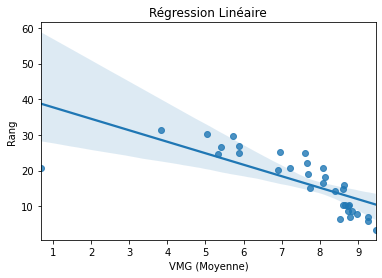

In [20]:
plt.figure()
data_ = df_une_semaine.sort_values(by = ['Rang'])
sns.regplot(x = data_['VMG (Moyenne)'], y = data_['Rang'])
plt.title('Régression Linéaire')
plt.show()

On remarque sur la figure ci-dessus que notre hypothèse soulevée précédemment semble être correcte : Plus la `Vitesse` augmente et plus le `Rang` diminue (le `Skipper` est mieux classé) et inversement.

<Figure size 432x288 with 0 Axes>

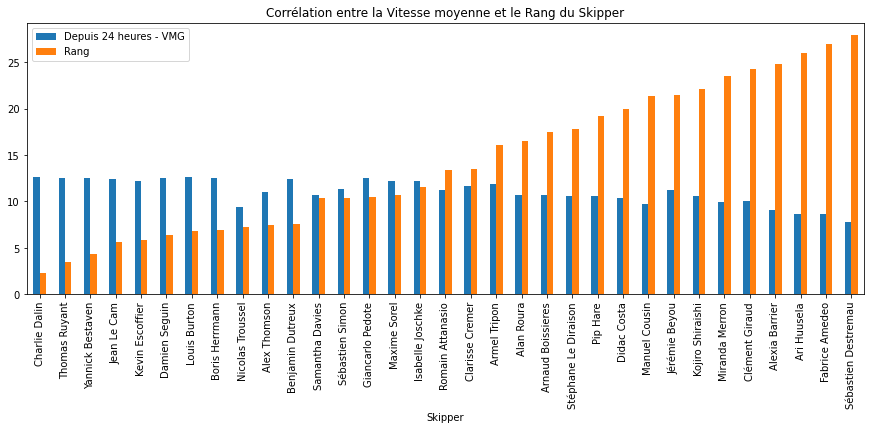

In [21]:
plt.figure()
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plot = data[['Depuis 24 heures - VMG', 'Rang', 'Skipper']].groupby('Skipper'). \
       mean(['Depuis 24 heures - VMG', 'Rang']).sort_values('Rang', ascending=True)
plot.plot.bar(ax = ax)
ax.set(xlabel = 'Skipper')
ax.set_title('Corrélation entre la Vitesse moyenne et le Rang du Skipper')
plt.show()

### Impact de la présence d'un foil sur le classement et la vitesse des voiliers

In [22]:
data[['Rang', 'Depuis 24 heures - VMG', 'Dérive / Foil']].corr()

,Rang,Depuis 24 heures - VMG,Dérive / Foil
Rang,1.000000,-0.378791,-0.329886
Depuis 24 heures - VMG,-0.378791,1.000000,0.143254
Dérive / Foil,-0.329886,0.143254,1.000000


On remarque que la présence d'un `Foil` est positivement corrélée avec la `Vitesse` et négativement corrélée avec le  `Rang`; Il est donc raisonnable de tirer la conclusion que la présence d'un `Foil` permet d'augmenter la `Vitesse`, et par conséquent d'améliorer le `Rang` des `Skippers`

### Machine Learning

Il nous est possible d'utiliser des algorithmes de machine learning pour chercher à prédire le `Rang` des `Skippers` à partir des données vues précédemment (`Vitesse`, `Foil`, `Ancienneté du bateau`, etc.). Nous nous retrouvons dans un cas `supervisé` où l'on cherche à prédire une valeur continue $\longrightarrow$ `régression`.

On pourra donc s'intéressé aux algortihmes de machine learning suivants :

- KNN

- Régression Linéaire

- Arbre de décision

On crée une sauvegarde des données

In [23]:
ML_data = df_features.copy()

On sépare les variables descriptives de la variable à prédire

In [24]:
X = ML_data.drop('Rang', axis = 1)
y = ML_data['Rang']

On `split` nos données en jeu d'entraînement et jeu de test

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Algorithme des k plus proches voisins

Nous devons premièrement trouver une valeur acceptable de `k` (nombre de voisins à prendre en considération) pour éviter l'overfitting et avoir de bonnes prédiction. Pour cela nous allons afficher la `MSE` en faisant tourner l'algorithme `KNeighborsRegressor` sur un nombre `N` de voisins

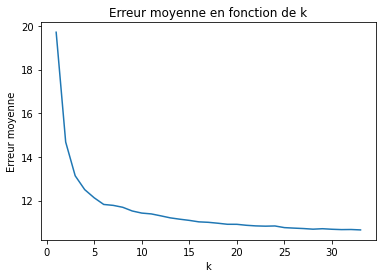

In [26]:
mean_squared_error = []

N = 33 #Nombre de Skippers

for k in range(1, N + 1) :
    model = KNeighborsRegressor(n_neighbors = k).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mean_squared_error.append(MSE(y_test, y_pred))
    
plt.figure()
plt.plot(range(1, N + 1), mean_squared_error)
plt.title("Erreur moyenne en fonction de k")
plt.xlabel("k")
plt.ylabel("Erreur moyenne")
plt.show()

En se référant au graphe ci-dessus il nous est possible de conclure qu'une valeure de `k = 20` permettra l'obtention de bons résultats, tout en évitant l'overfitting.

In [27]:
model = KNeighborsRegressor(n_neighbors = 20).fit(X_train,y_train)
y_pred = np.round(model.predict(X_test), 0)

accuracy = accuracy_score(y_test, y_pred)

recall = recall_score(y_test, y_pred, average = 'macro')

f1 = f1_score(y_test, y_pred, average = 'macro')

r2 = r2_score(y_test, y_pred)

print("Accuracy :", accuracy)
print("Recall :",recall)
print("f1_score :", f1)
print("r2_score :", r2)

Accuracy : 0.21112929623567922
Recall : 0.19391635950437652
f1_score : 0.18802133140920563
r2_score : 0.8375326472178435


Les résultats n'ont pas l'air très concluants en utilisant l'algortihme du `kNN`, nous nous intéresserons à un autre algorithme pour voir si l'on peut obtenir de meilleurs résultats.

### Algorithme des arbres de décisions

In [28]:
model = DecisionTreeRegressor().fit(X_train,y_train)
y_pred = np.round(model.predict(X_test))

accuracy = accuracy_score(y_test,y_pred)

precision = precision_score(y_test, y_pred, average ='macro', zero_division=1)

recall = recall_score(y_test, y_pred, average ='macro')

f1 = f1_score(y_test, y_pred, average ='macro')

r2 = r2_score(y_test, y_test)

print("Accuracy :", accuracy)
print("Precision :", precision)
print("Recall :", recall)
print("f1_score :", f1)
print("r2_score :", r2)

Accuracy : 0.22684124386252047
Precision : 0.22841386021249876
Recall : 0.2226360964843539
f1_score : 0.21568868488895568
r2_score : 1.0


Comme pour l'algorithme du `kNN`, on remarque que les résultats obtenus en utilisant l'algorithme des `Arbres de Décisions` ne sont pas très concluants.

### Algorithme de Régression Linéaire

Pour ce dernier algorithme nous allons retirer la colonne contenant les données pour les `Dérive / Foil` car elle semble fausser les résultats

In [29]:
X_train = X_train.drop('Dérive / Foil', axis = 1)
X_test = X_test.drop('Dérive / Foil', axis = 1)

In [30]:
model = LinearRegression(y_train, X_train).fit()

y_pred = np.round(model.predict(X_test), 0)

accuracy = accuracy_score(y_test,y_pred)

precision = precision_score(y_test, y_pred, average ='macro', zero_division=1)

recall = recall_score(y_test, y_pred, average ='macro', zero_division=1)

f1 = f1_score(y_test, y_pred, average ='macro')

r2 = r2_score(y_test, y_test)

print("Accuracy :", accuracy)
print("Precision :", precision)
print("Recall :", recall)
print("f1_score :", f1)
print("r2_score :", r2)

Accuracy : 0.0618657937806874
Precision : 0.18481518020471424
Recall : 0.05331479046032947
f1_score : 0.04644858795748178
r2_score : 1.0


Les résultats pour la `LinearRegression` sont encore moins bons que ceux observés par les deux algorithmes précédents. On peut cependant s'intéresser aux caractéristiques de cette dernière.

In [31]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Rang   R-squared (uncentered):                   0.860
Model:                            OLS   Adj. R-squared (uncentered):              0.860
Method:                 Least Squares   F-statistic:                          1.070e+04
Date:                Sun, 04 Dec 2022   Prob (F-statistic):                        0.00
Time:                        20:11:47   Log-Likelihood:                         -40232.
No. Observations:               12217   AIC:                                  8.048e+04
Df Residuals:                   12210   BIC:                                  8.053e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Depuis 24 heures - VMG          -0.5823      0.016    -35.632      0.000      -0.614      -0.550
Largeur                         -7.0513      0.400    -17.642      0.000      -7.835      -6.268
Déplacement (poids)              3.2086      0.175     18.329      0.000       2.865       3.552
Hauteur mât                      1.8629      0.073     25.433      0.000       1.719       2.006
Surface de voiles au près       -0.0861      0.003    -34.344      0.000      -0.091      -0.081
Surface de voiles au portant     0.0116      0.002      7.658      0.000       0.009       0.015
Ancienneté du bateau             0.0003   4.32e-05      8.083      0.000       0.000       0.000
==============================================================================
Omnibus:                      500.976   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              583.517
Skew:                           0.481   Prob(JB):                    1.95e-127
Kurtosis:                       3.469   Cond. No.                     3.74e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.74e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Conclusions

On remarque que la `Vitesse`, la `Largeur` et le `Déplacement (poids)` avantagent le `Skipper`, contrairement à la `Hauteur du mât` qui le désaventage. L'`Ancienneté du bateau` ne semble pas être une caractéristique qui influence les résultats.

Il semble qu'il soit impossible de prédire le classement des `Skippers` à l'aide d'algorithmes de Machine Learning; On peut s'imaginer que la raison de cette occurence est liée à des caractéristiques qu'il est impossible de mesurer : tel que le talent du `Skipper` mais également un facteur de chance aléatoire.

### Détection de Foil

Nous allons maintenant nous intéressé à la prédiction de la présence d'un foil sur un bateau en fonction des caractéristiques de ce dernier

In [32]:
y = X['Dérive / Foil']
X = X.drop('Dérive / Foil', axis = 1)

Nous somme désormais dans un problème de classification binaire

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

### Algorithme des k plus proches voisins

In [34]:
model = KNeighborsClassifier(n_neighbors = 20).fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

precision = precision_score(y_test, y_pred, average = 'macro')

recall = recall_score(y_test, y_pred, average = 'macro')

f1 = f1_score(y_test, y_pred, average = 'macro')

r2 = r2_score(y_test, y_pred)

print("Accuracy :", accuracy)
print("Precision :",precision)
print("Recall :",recall)
print("f1_score :", f1)
print("r2_score :", r2)

Accuracy : 1.0
Precision : 1.0
Recall : 1.0
f1_score : 1.0
r2_score : 1.0


In [35]:
model = DecisionTreeClassifier().fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test,y_pred)

precision = precision_score(y_test, y_pred, average ='macro', zero_division=1)

recall = recall_score(y_test, y_pred, average ='macro')

f1 = f1_score(y_test, y_pred, average ='macro')

r2 = r2_score(y_test, y_test)

print("Accuracy :", accuracy)
print("Precision :", precision)
print("Recall :", recall)
print("f1_score :", f1)
print("r2_score :", r2)

Accuracy : 1.0
Precision : 1.0
Recall : 1.0
f1_score : 1.0
r2_score : 1.0


### Algorithme de la Régression Logistique

In [36]:
model = LogisticRegression(max_iter=1000).fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

precision = precision_score(y_test, y_pred, average ='macro')

recall = recall_score(y_test, y_pred, average ='macro')

r2 = r2_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average ='macro')

print("Accuracy :", accuracy)
print("Precision :", precision)
print("Recall :", recall)
print("f1_score :", f1)
print("r2_score :", r2)

Accuracy : 0.904418985270049
Precision : 0.9219668626402993
Recall : 0.9010840108401084
f1_score : 0.9027939413751771
r2_score : 0.6172408525858533


#### Conclusion

On remarque qu'il est très simple de prédire avec une quasi-certitude la présence d'un foil sur un bateau à l'aide de ses charactéristiques ainsi que de sa vitesse.

## Cartes avec les routes d'un ou plusieurs voiliers.

In [37]:
geo = data.copy()

geo = geo[['Skipper', 'Latitude', 'Longitude', 'Date']]

geo = (geo.set_index(['Skipper', 'Date'])).sort_values(by = 'Skipper').unstack()
geo = geo.swaplevel(axis=1).stack()

On retire les `NaN` en laissant persister la dernière position connue du `Skipper`

In [38]:
geo = geo.ffill(axis = 1)
geo = geo.bfill(axis = 1)

In [39]:
geo.head(20)

Date                         2020-11-08 15:00:00  2020-11-08 16:00:00  \
Skipper                                                                 
Alan Roura        Latitude             46.436667            46.358889   
                  Longitude            -1.826667            -2.370278   
Alex Thomson      Latitude             46.422500            46.318889   
                  Longitude            -1.829167            -2.535000   
Alexia Barrier    Latitude             46.439722            46.368056   
                  Longitude            -1.825556            -2.294722   
Ari Huusela       Latitude             46.434722            46.302500   
                  Longitude            -1.805833            -2.233333   
Armel Tripon      Latitude             46.426667            46.342778   
                  Longitude            -1.817500            -2.484444   
Arnaud Boissieres Latitude             46.411944            46.411944   
                  Longitude            -4.288333            -4.288333   
Benjamin Dutreux  Latitude             46.429722            46.357500   
                  Longitude            -1.820556            -2.336667   
Boris Herrmann    Latitude             46.409444            46.306111   
                  Longitude            -1.839444            -2.500833   
Charlie Dalin     Latitude             46.296111            46.296111   
                  Longitude            -2.529167            -2.529167   
Clarisse Cremer   Latitude             46.438333            46.318889   
                  Longitude            -1.817500            -2.362222   

Date                         2020-11-08 18:00:00  2020-11-08 22:00:00  \
Skipper                                                                 
Alan Roura        Latitude             46.391111            46.470000   
                  Longitude            -3.066111            -4.426389   
Alex Thomson      Latitude             46.259167            46.151389   
                  Longitude            -3.326111            -4.669167   
Alexia Barrier    Latitude             46.378611            46.266667   
                  Longitude            -2.858056            -3.969444   
Ari Huusela       Latitude             46.234167            45.973056   
                  Longitude            -2.701389            -3.780833   
Armel Tripon      Latitude             46.358056            46.237222   
                  Longitude            -3.342778            -5.022500   
Arnaud Boissieres Latitude             46.411944            46.411944   
                  Longitude            -4.288333            -4.288333   
Benjamin Dutreux  Latitude             46.325278            46.292778   
                  Longitude            -2.995000            -4.393056   
Boris Herrmann    Latitude             46.284444            46.240556   
                  Longitude            -3.319722            -4.767778   
Charlie Dalin     Latitude             46.275556            46.175833   
                  Longitude            -3.377500            -4.795000   
Clarisse Cremer   Latitude             46.267778            46.189444   
                  Longitude            -3.043889            -4.410278   

Date                         2020-11-09 05:00:00  2020-11-09 09:00:00  \
Skipper                                                                 
Alan Roura        Latitude             46.339444            46.441944   
                  Longitude            -6.205833            -7.121111   
Alex Thomson      Latitude             46.490833            46.540556   
                  Longitude            -6.891389            -7.723889   
Alexia Barrier    Latitude             46.280833            46.420278   
                  Longitude            -5.621111            -6.416667   
Ari Huusela       Latitude             45.931111            45.905556   
                  Longitude            -4.928333            -5.688889   
Armel Tripon      Latitude             46.491389        

In [41]:
skippers = geo.index.levels[0].tolist()

coordonnées = np.arange(start=2, stop=len(geo), step=2)

map_skippers = go.Figure(go.Scattermapbox(mode = "markers+lines",
                                          lon = geo.iloc[1].tolist(),
                                          lat = geo.iloc[0].tolist(),
                                          marker = {'size': 3},
                                          name = skippers[0],
                                          hovertext = skippers[0]))

for x in coordonnées :
    map_skippers.add_trace(go.Scattermapbox(mode = "markers+lines",
                                            lon = geo.iloc[x+1],
                                            lat = geo.iloc[x],
                                            marker = {'size': 3},
                                            name = skippers[int(x/2)],
                                            hovertext = skippers[int(x/2)]))

map_skippers.update_layout(margin ={'l':0,'t':0,'b':0,'r':0},
                           mapbox = {'center': {'lon': 10, 'lat': 10},
                                     'style': "stamen-terrain",
                                     'center': {'lon': -2, 'lat': 45},
                                     'zoom': 1})

map_skippers.show()